## Overview

This notebook will take a look at agaricus dataset (Mushroom Database) originally drawn from The Audubon Society Field Guide to North American Mushrooms and hosted in the UCI Machine Learning Repository. 

The goal is to create model that can accurately differentiate between edible and poisonous mushrooms.

To do this two models will be used:
* sklearn's RandomForestClassifer
* XGBoost's XGBClassifier

Each model will be used on both a simple numeric mapping and a one-hot encoding of the dataset. In addition to model performance, feature importances will be examined for each model and decision trees built when possible.

SHAP and permutation importance will be used to further dive into feature contributions.

In [39]:
from collections import Counter
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report,confusion_matrix
#import category_encoders as ce
from six import StringIO
from IPython.display import Image  
from sklearn import tree
import pydotplus
import shap
import eli5
import lime
import statsmodels.api as sm
import scipy.stats as ss

In [3]:
RS = 404 # global random state/seed to use
pd.set_option('max_columns',25)

## Data

The dataset may be obtained from:

https://archive.ics.uci.edu/ml/datasets/mushroom or https://www.kaggle.com/uciml/mushroom-classification

Additionally, a dataset is used from the XGBoost repository which can be found here:<br>
https://github.com/dmlc/xgboost/tree/master/demo/data


The Kaggle link is preferred simply for convenience as the columns have already been labeled with sensible names.


This dataset includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family Mushroom drawn from The Audubon Society Field Guide to North American Mushrooms (1981). Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous one.

Each entry in dataset contains only a single letter, a reference table containing corresponding meanings can be found at https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names

UCI Machine Learning Repository data:
```
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data
```
XGBoost data:
```
!wget https://raw.githubusercontent.com/dmlc/xgboost/master/demo/data/agaricus.txt.train
!wget https://raw.githubusercontent.com/dmlc/xgboost/master/demo/data/agaricus.txt.test
!wget https://raw.githubusercontent.com/dmlc/xgboost/master/demo/data/featmap.txt
```

In [4]:
agar = pd.read_csv('data/mushrooms.csv',dtype='category')
# replace dash with underscore for dot access
agar.columns = agar.columns.str.replace('-','_')
# class is python reserved keyword, also impedes dot access
agar.rename(columns={'class':'toxic'},inplace=True)

In [5]:
agar.head()

,toxic,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


## Exploratory Data Analysis

Short of one variable having with NA values, this dataset is quite clean. It is entirely comprised of categorical values, each with a relatively low cardinality. It is slightly imbalanced, having 4208 (51.8%) entries marked as edible and 3916 (48.2%) marked poisonous, a small discrepancy, but it shouldn't have a significant affect on our model, however.

In [5]:
agar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
toxic                       8124 non-null category
cap_shape                   8124 non-null category
cap_surface                 8124 non-null category
cap_color                   8124 non-null category
bruises                     8124 non-null category
odor                        8124 non-null category
gill_attachment             8124 non-null category
gill_spacing                8124 non-null category
gill_size                   8124 non-null category
gill_color                  8124 non-null category
stalk_shape                 8124 non-null category
stalk_root                  8124 non-null category
stalk_surface_above_ring    8124 non-null category
stalk_surface_below_ring    8124 non-null category
stalk_color_above_ring      8124 non-null category
stalk_color_below_ring      8124 non-null category
veil_type                   8124 non-null category
veil_color                

At first glance, it appears as though there are no NA values but from reading the data description we know that `stalk_root` does have null values, they are just labeled with a '?'

In [6]:
agar.stalk_root.value_counts()

b    3776
?    2480
e    1120
c     556
r     192
Name: stalk_root, dtype: int64

Since there is only one variable with any missing values and we are about to encode everything anyway, there is no point in replacing it with np.nan

In [7]:
agar.nunique().sort_values(ascending=False)

gill_color                  12
cap_color                   10
spore_print_color            9
odor                         9
stalk_color_below_ring       9
stalk_color_above_ring       9
habitat                      7
population                   6
cap_shape                    6
stalk_root                   5
ring_type                    5
stalk_surface_above_ring     4
stalk_surface_below_ring     4
veil_color                   4
cap_surface                  4
ring_number                  3
stalk_shape                  2
gill_size                    2
gill_spacing                 2
gill_attachment              2
bruises                      2
toxic                        2
veil_type                    1
dtype: int64

`veil_type` only has 1 entry, so it adds no information to our model and can be safely dropped.

In [6]:
agar_enc = agar.drop(columns='veil_type').apply(lambda x: x.cat.codes)

In [7]:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://github.com/shakedzy/dython
def conditional_entropy(x, y):
    """Calculates the conditional entropy of x given y: S(x|y)

    Parameters
    ----------
    x,y : array-like, int-encoded categorical value arrays
    
    Returns
    -------
    entropy : float
    
    See Also
    --------
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    
    """
    y=y.astype(np.int64)
    y_counter = np.bincount(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = y_counter.sum()
    entropy = 0.0
    for k,v in xy_counter.items():
        p_xy = v / total_occurrences
        p_y = y_counter[k[1]] / total_occurrences
        entropy += p_xy * np.log(p_y/p_xy)
    return entropy

def cramers_v(x, y):
    """
    Calculates Cramer's V statistic for categorical-categorical association.
    Uses correction from Bergsma and Wicher, Journal of the Korean Statistical Society 42 (2013): 323-328.
    This is a symmetric coefficient: V(x,y) = V(y,x)

    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
        
    Returns 
    -------
    float, between range [0,1]
    
    See Also
    --------
    Original function from: https://stackoverflow.com/a/46498792/5863503
    Wikipedia: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
    
def theils_u(x, y):
    """Calculates Theil's U statistic (Uncertainty coefficient) for categorical-categorical association.
   
    This is the uncertainty of x given y: value is on the range of [0,1] 
    - where 0 means y provides no information about x, 
    and 1 means y provides full information about x.
    This is an asymmetric coefficient: U(x,y) != U(y,x)
    
    Parameters
    ----------
    x,y : array-like, int-encoded categorical value arrays
    
    Returns
    -------
    uncertainity coefficent : float between [0,1]
    
    See Also
    --------
    Wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient
    """
    x=x.astype(np.int64)
    s_xy = conditional_entropy(x,y)
    x_counter = np.bincount(x)
    total_occurrences = x_counter.sum()
    p_x = x_counter/total_occurrences
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    return (s_x - s_xy) / s_x

def catcorr(data, method='theils'):
    """ Compute categorical correlations using uncertainty coefficients (Theil's U) or Cramer's V
    
    Parameters
    ----------
    data : pandas.DataFrame 
        dataset used to compute correlations 
    method - str, ['theils' | 'cramers']
        method to calculate correlations, cramers is symmetric, theils is asymmetric
    
    Returns
    -------
        computed correlations : pandas.DataFrame
    """
    if method == 'cramers':
        return data.corr(method=cramers_v)
    elif method != 'theils':
        raise NotImplementedError(f"method: '{method}' not implemented, choose either 'cramers' or 'theils'")
    cols = data.columns
    clen = cols.size
    
    pairings = list(itertools.product(data.columns, repeat=2))
    theils_mat = np.reshape([theils_u(data[p[1]],data[p[0]]) for p in pairings],(clen,clen))
    return pd.DataFrame(theils_mat, index=cols, columns=cols)

Since we are working with all categorical values a traditional correlation matrix will not suffice. Instead, we'll be using an [uncertainty coefficient](https://en.wikipedia.org/wiki/Uncertainty_coefficient) matrix to model the asymmetric relationships between value pairs. The functions used are slight modifications of those in the [dython package](https://github.com/shakedzy/dython), modified to prefer performance over flexibility.

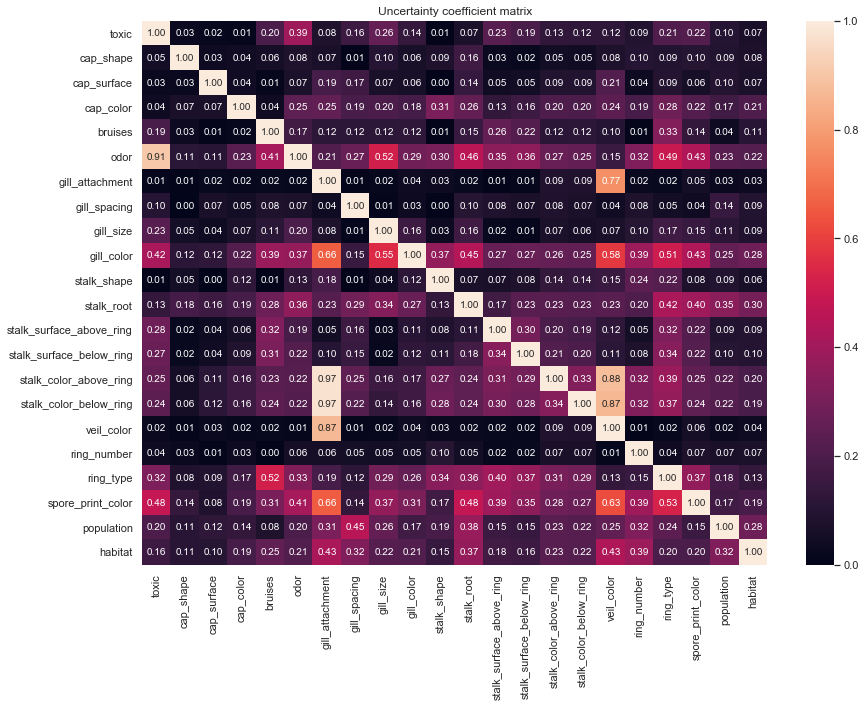

In [8]:
fig, ax = plt.subplots(1,1, figsize=(14,10))
sns.heatmap(catcorr(agar_enc),0,1,ax=ax,annot=True,fmt="0.2f").set_title("Uncertainty coefficient matrix")
plt.show()

The matrix reveals a few key findings, first and foremost, given we know `oder` we already have a substantial amount of information pertaining to the response, `toxic`. This will be very important to keep in mind as a we move forward with the analysis. 

Additional there is a near symmetric relationship among `veil_color` and the `stalk_color*` features, this relationship is not true across all color attributes, however, as seen by `spore_print_color`, `gill_print_color`, and `cap_color`.

In [15]:
X,y = agar.drop(columns=['toxic','veil_type']), agar.toxic
X_enc, y_enc = X.apply(lambda x: x.cat.codes), y.cat.codes # numericize

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=.20, random_state=RS)

dataset just using the categorical encoded dataset. 

In [17]:
Xoh = pd.get_dummies(X, drop_first=False)
Xoh_train, Xoh_test, yoh_train, yoh_test = train_test_split(Xoh, y, test_size=.20, random_state=RS)
X.shape,Xoh.shape

((8124, 21), (8124, 116))

Using a simple one-hot encoding increases the feature count to 116, though it makes the data rather sparse, it is not unreasonable in size since we started with only 21 features and a max cardinality of 12.

In [18]:
Xoh.head()

,cap_shape_b,cap_shape_c,cap_shape_f,cap_shape_k,cap_shape_s,cap_shape_x,cap_surface_f,cap_surface_g,cap_surface_s,cap_surface_y,cap_color_b,cap_color_c,...,population_c,population_n,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0


## Models

Two models will be used: sklearn's RandomForestClassifier and XGBoostClassifier

In [20]:
# New pretty confusion matrix plotting to remove itertools dependency
def pplot_cm(y_true, y_pred, labels, filename=None, ymap=None, cf_report=False, figsize=(7,5), **kwargs):
    """
    Pretty plot a confusion matrix with annotations.
    Optionally save plot image to disk.
    
    Args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    array of shape [n_class,] name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      cf_report: if True, print a classification report in addition to confusion matrix
      figsize:   the size of the figure plotted.
      **kwargs:  keyword arguments to pass to seaborn's heatmap
      
    See also:
        https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    if cf_report: print(classification_report(y_true,y_pred))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, **kwargs)
    plt.savefig(filename) if filename is not None else plt.show()

### Random Forest

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       840
           1       1.00      1.00      1.00       785

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



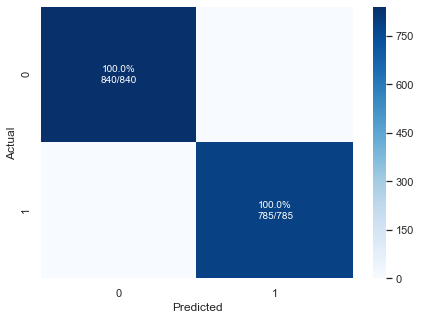

In [21]:
rfc = RandomForestClassifier(100 ,n_jobs=-1, random_state=RS)
rfc.fit(X_train,y_train)
preds = rfc.predict(X_test)
pplot_cm(y_test, preds, rfc.classes_, cf_report=True, figsize=(7,5), cmap='Blues')

Our Random Forest model yielded perfect scores across the board. Now, this may seem like fantastic news, but anytime you have a perfectly performing model it should be met with a great deal of skepticism. The majority of the time, it means there is either data leakage somewhere in the dataset or some mistake made during modeling or data prep. Perhaps testing data was accidentally introduced during training, or one of the input variables is perfectly correlated with the target, or maybe the chosen train/test split just happened to pick an easy subset.

From the uncertainty coefficients matrix, we know that there is no perfect correlation between any variables and the target, and there does not appear to be any overlap between train and test data. So, we'll see if luck was the answer by doing k-fold validation.

In [27]:
skf = StratifiedKFold(5, shuffle=True, random_state=RS)
rfc = RandomForestClassifier(100, n_jobs=-1,random_state=RS)

In [35]:
for train_idx, test_idx in skf.split(X_enc, y_enc):
    X_train, X_test, y_train, y_test = X_enc.loc[train_idx], X_enc.loc[test_idx], y_enc[train_idx], y_enc[test_idx]
    rfc.fit(X_train,y_train)
    y_pred = rfc.predict(X_test)
    print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       784

    accuracy                           1.00      1626
   macro avg       1.00      1.00      1.00      1626
weighted avg       1.00      1.00      1.00      1626

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

              preci

Perfect across 5 folds, let's see how it does with 10.

In [37]:
metrics = ['precision','recall','f1','roc_auc']
scores = cross_validate(rfc, X_enc, y_enc, scoring=metrics, cv=10, return_train_score=True, n_jobs=-1)

for m in metrics:
    test_score, train_score = [scores[x] for x in scores.keys() if m in x]
    print(m+':\n','{:>4} train scores: {}'.format('',list(train_score)))
    print('{:>5} test scores: {}'.format('',list(test_score)))
    print('{:>5} test mean: {}'.format('',test_score.mean()))

precision:
      train scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
      test scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9678217821782178, 1.0]
      test mean: 0.9967821782178218
recall:
      train scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
      test scores: [0.3469387755102041, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
      test mean: 0.9346938775510203
f1:
      train scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
      test scores: [0.5151515151515151, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9836477987421384, 1.0]
      test mean: 0.9498799313893654
roc_auc:
      train scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
      test scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
      test mean: 1.0


It does indeed appear as though some subsets of the data were easier to predict than others but on the whole, we still have a very strong classifier, well above 90% on all metrics using 10-fold cross_validation.

This is with no tweaks to the model's hyperparameters at all, just the defaults. With a bit of tweaking near perfect predictions isn't out of the realm of possibility.

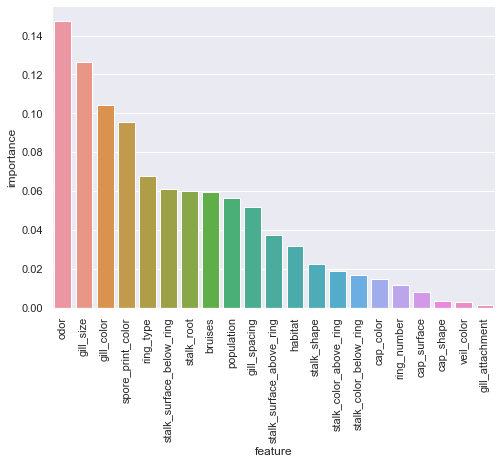

In [72]:
rfc_fi = pd.DataFrame({'feature':X.columns,'importance':rfc.feature_importances_}).sort_values(by='importance',ascending=False)
sns.catplot(x='feature',y='importance',data=rfc_fi,kind='bar',aspect=1.5).set_xticklabels(rotation=90);

`odor`, `gill_size`, `gill_color`, and `spore_print_color` encapsulate a large portion of the overall feature importance for the RandomForest model. Odor makes some intuitive sense even with no fungal knowledge. Generally, smell is a fairly strong indicator of whether or not something is safe to consume. Of course, given how we have chosen to represent the data, we do not have the level of detail required to know exactly what kind of smell means edible or poisonous.

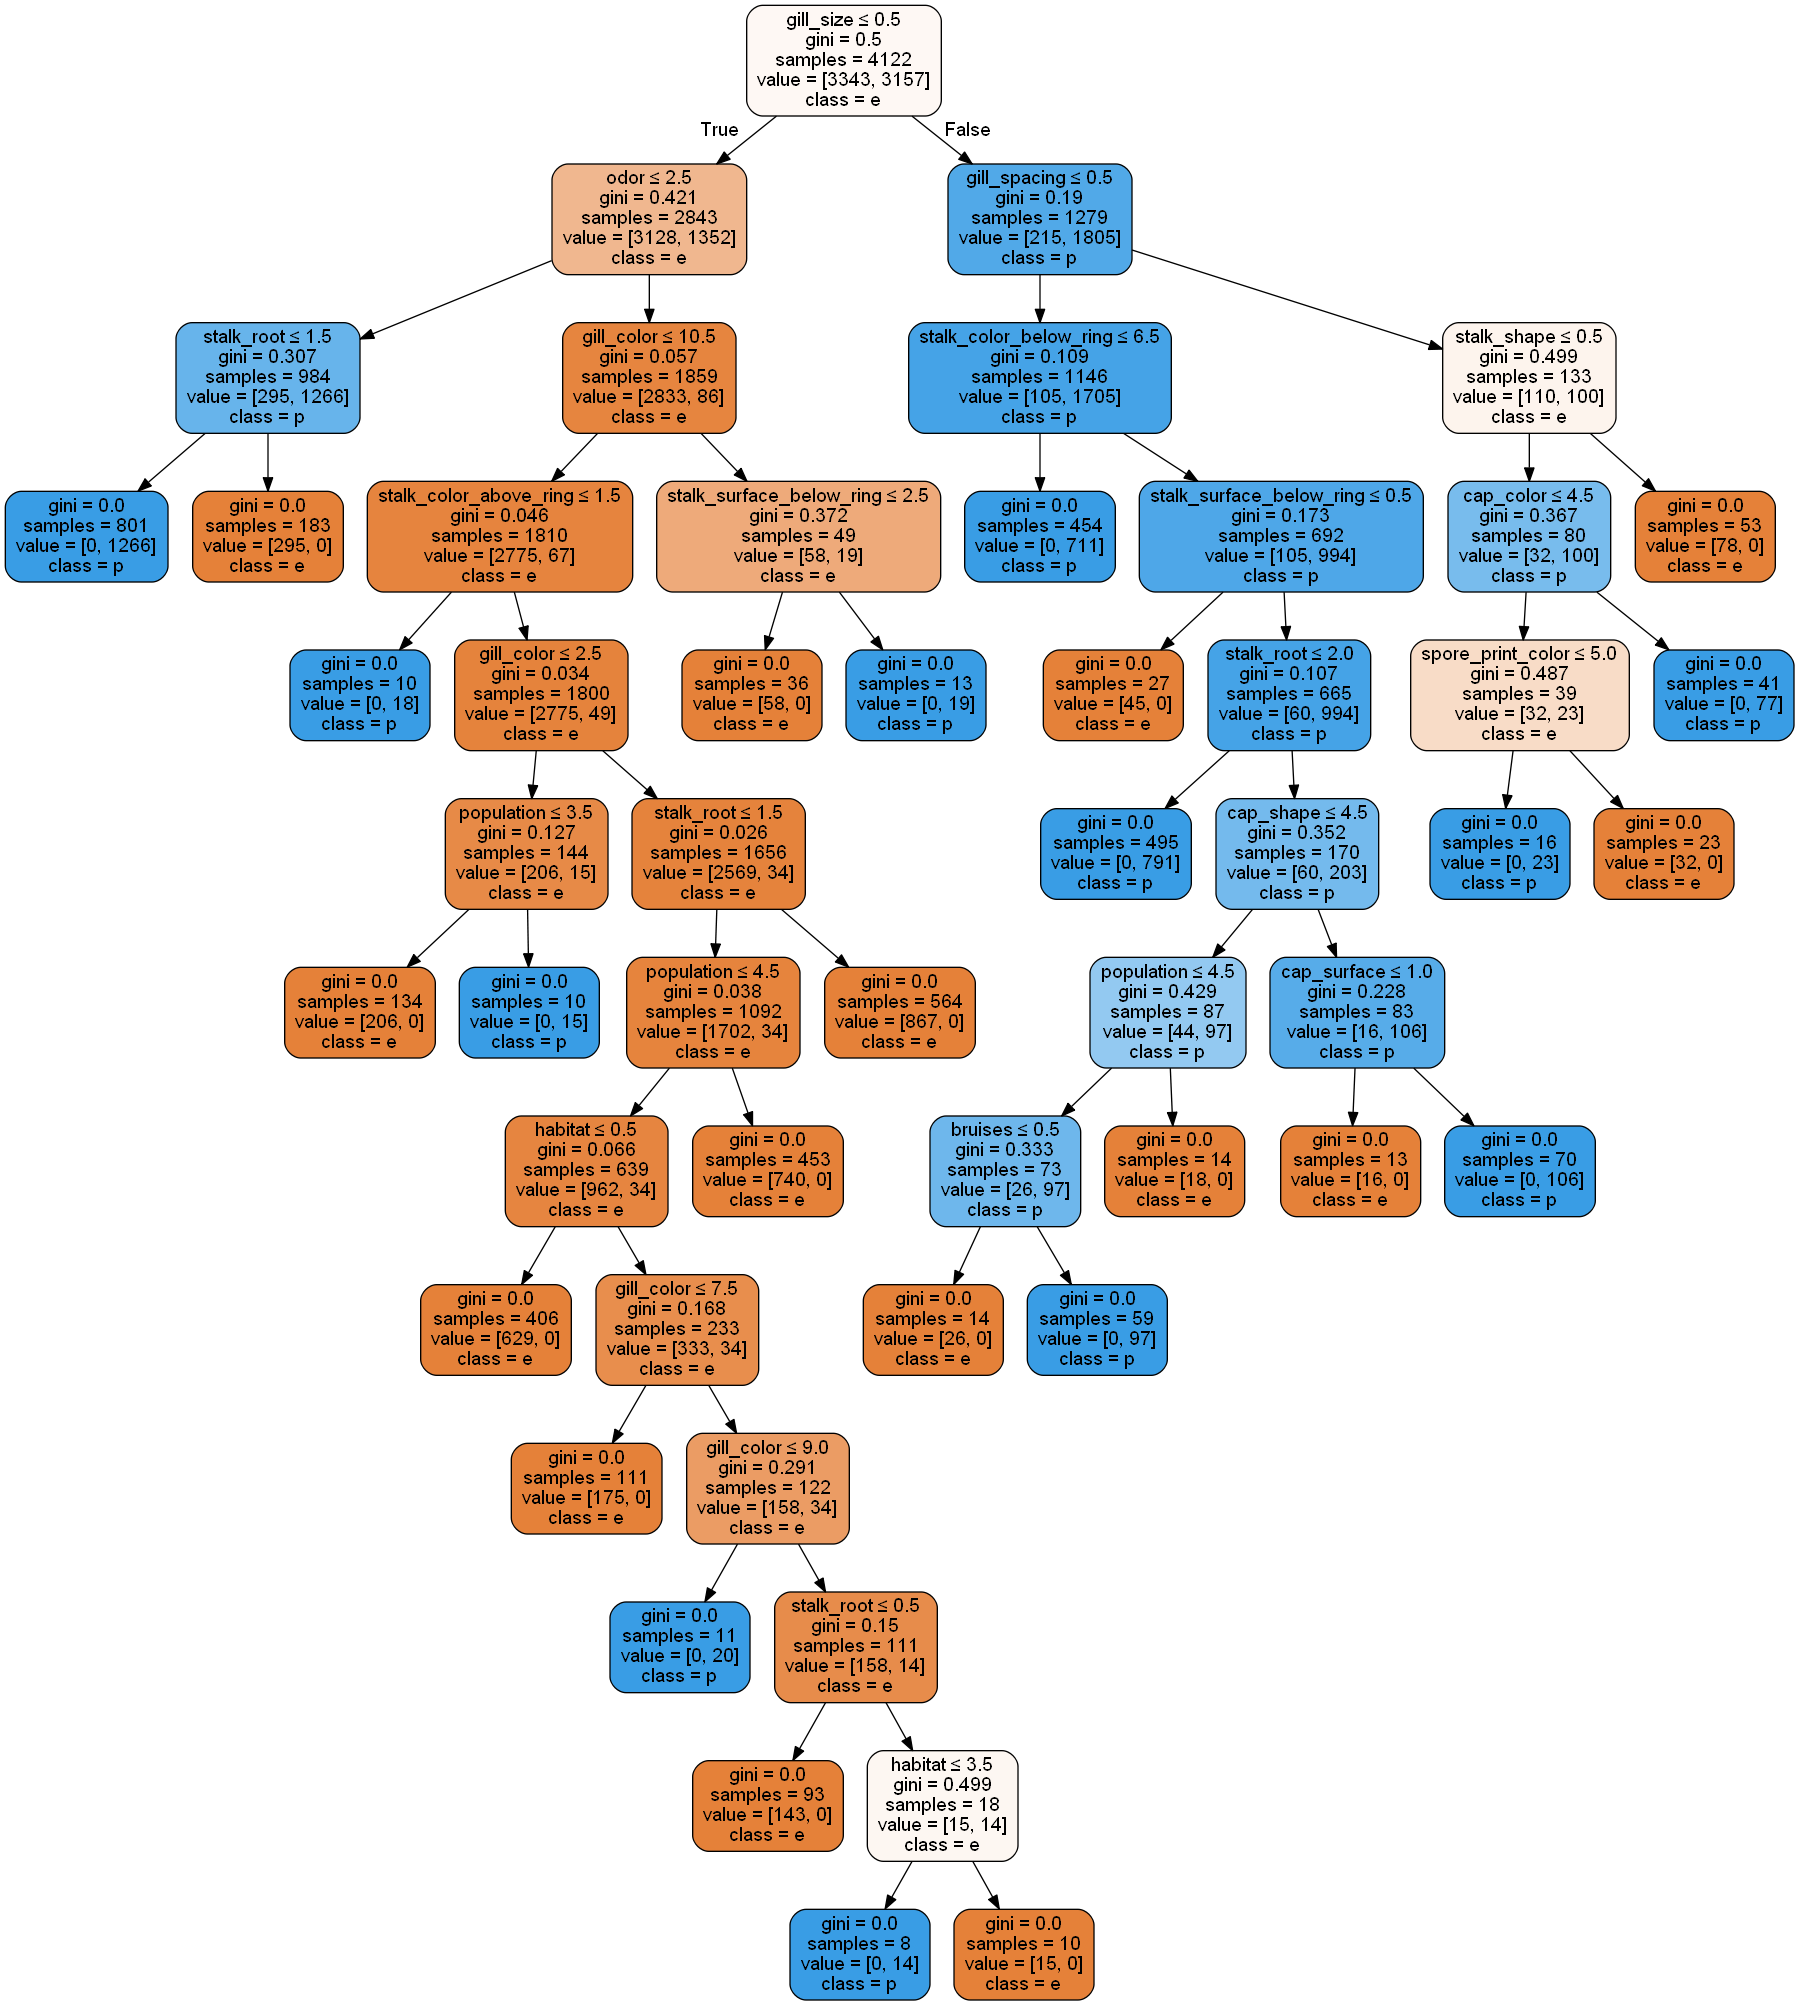

In [43]:
# https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176

dot_data = StringIO()
tree.export_graphviz(rfc.estimators_[7], out_file=dot_data, 
                feature_names=X.columns, class_names=['e','p'],
                filled=True, rounded=True, special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png(),width=600,height=800)

Reducing the random forest to a single decision tree gives some insight into the model's decision making process. However, it is not quite intuitive from a human rationalization standpoint. Next, we'll try using the one-hot encoded data to see if increased granularity provides easier interpretations.

#### One hot encoded

In [44]:
rfc_oh = RandomForestClassifier(100, n_jobs=-1,random_state=RS)
rfc_oh.fit(Xoh_train,yoh_train)
preds_oh = rfc_oh.predict(Xoh_test)

              precision    recall  f1-score   support

           e       1.00      1.00      1.00       840
           p       1.00      1.00      1.00       785

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



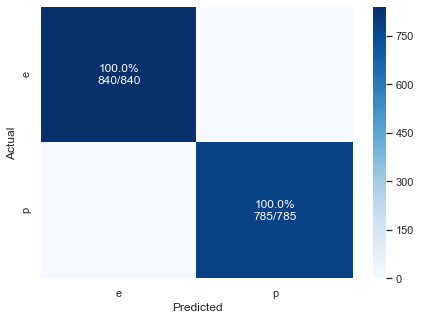

In [45]:
pplot_cm(yoh_test, preds_oh, rfc_oh.classes_, cf_report=True, figsize=(7,5), cmap='Blues')

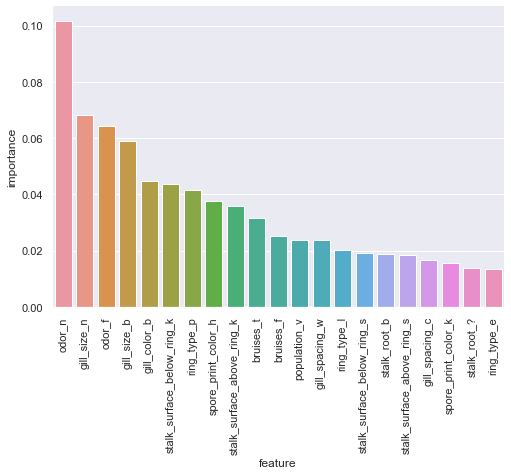

In [78]:
rfc_oh_fi = pd.DataFrame({'feature':Xoh.columns,'importance':rfc_oh.feature_importances_}).sort_values(by='importance',ascending=False)
sns.catplot(x='feature',y='importance',data=rfc_oh_fi[:21],kind='bar',aspect=1.5).set_xticklabels(rotation=90);

odor: none and odor: foul rank highest for one-hot encoded variables, again supporting intuitions. 

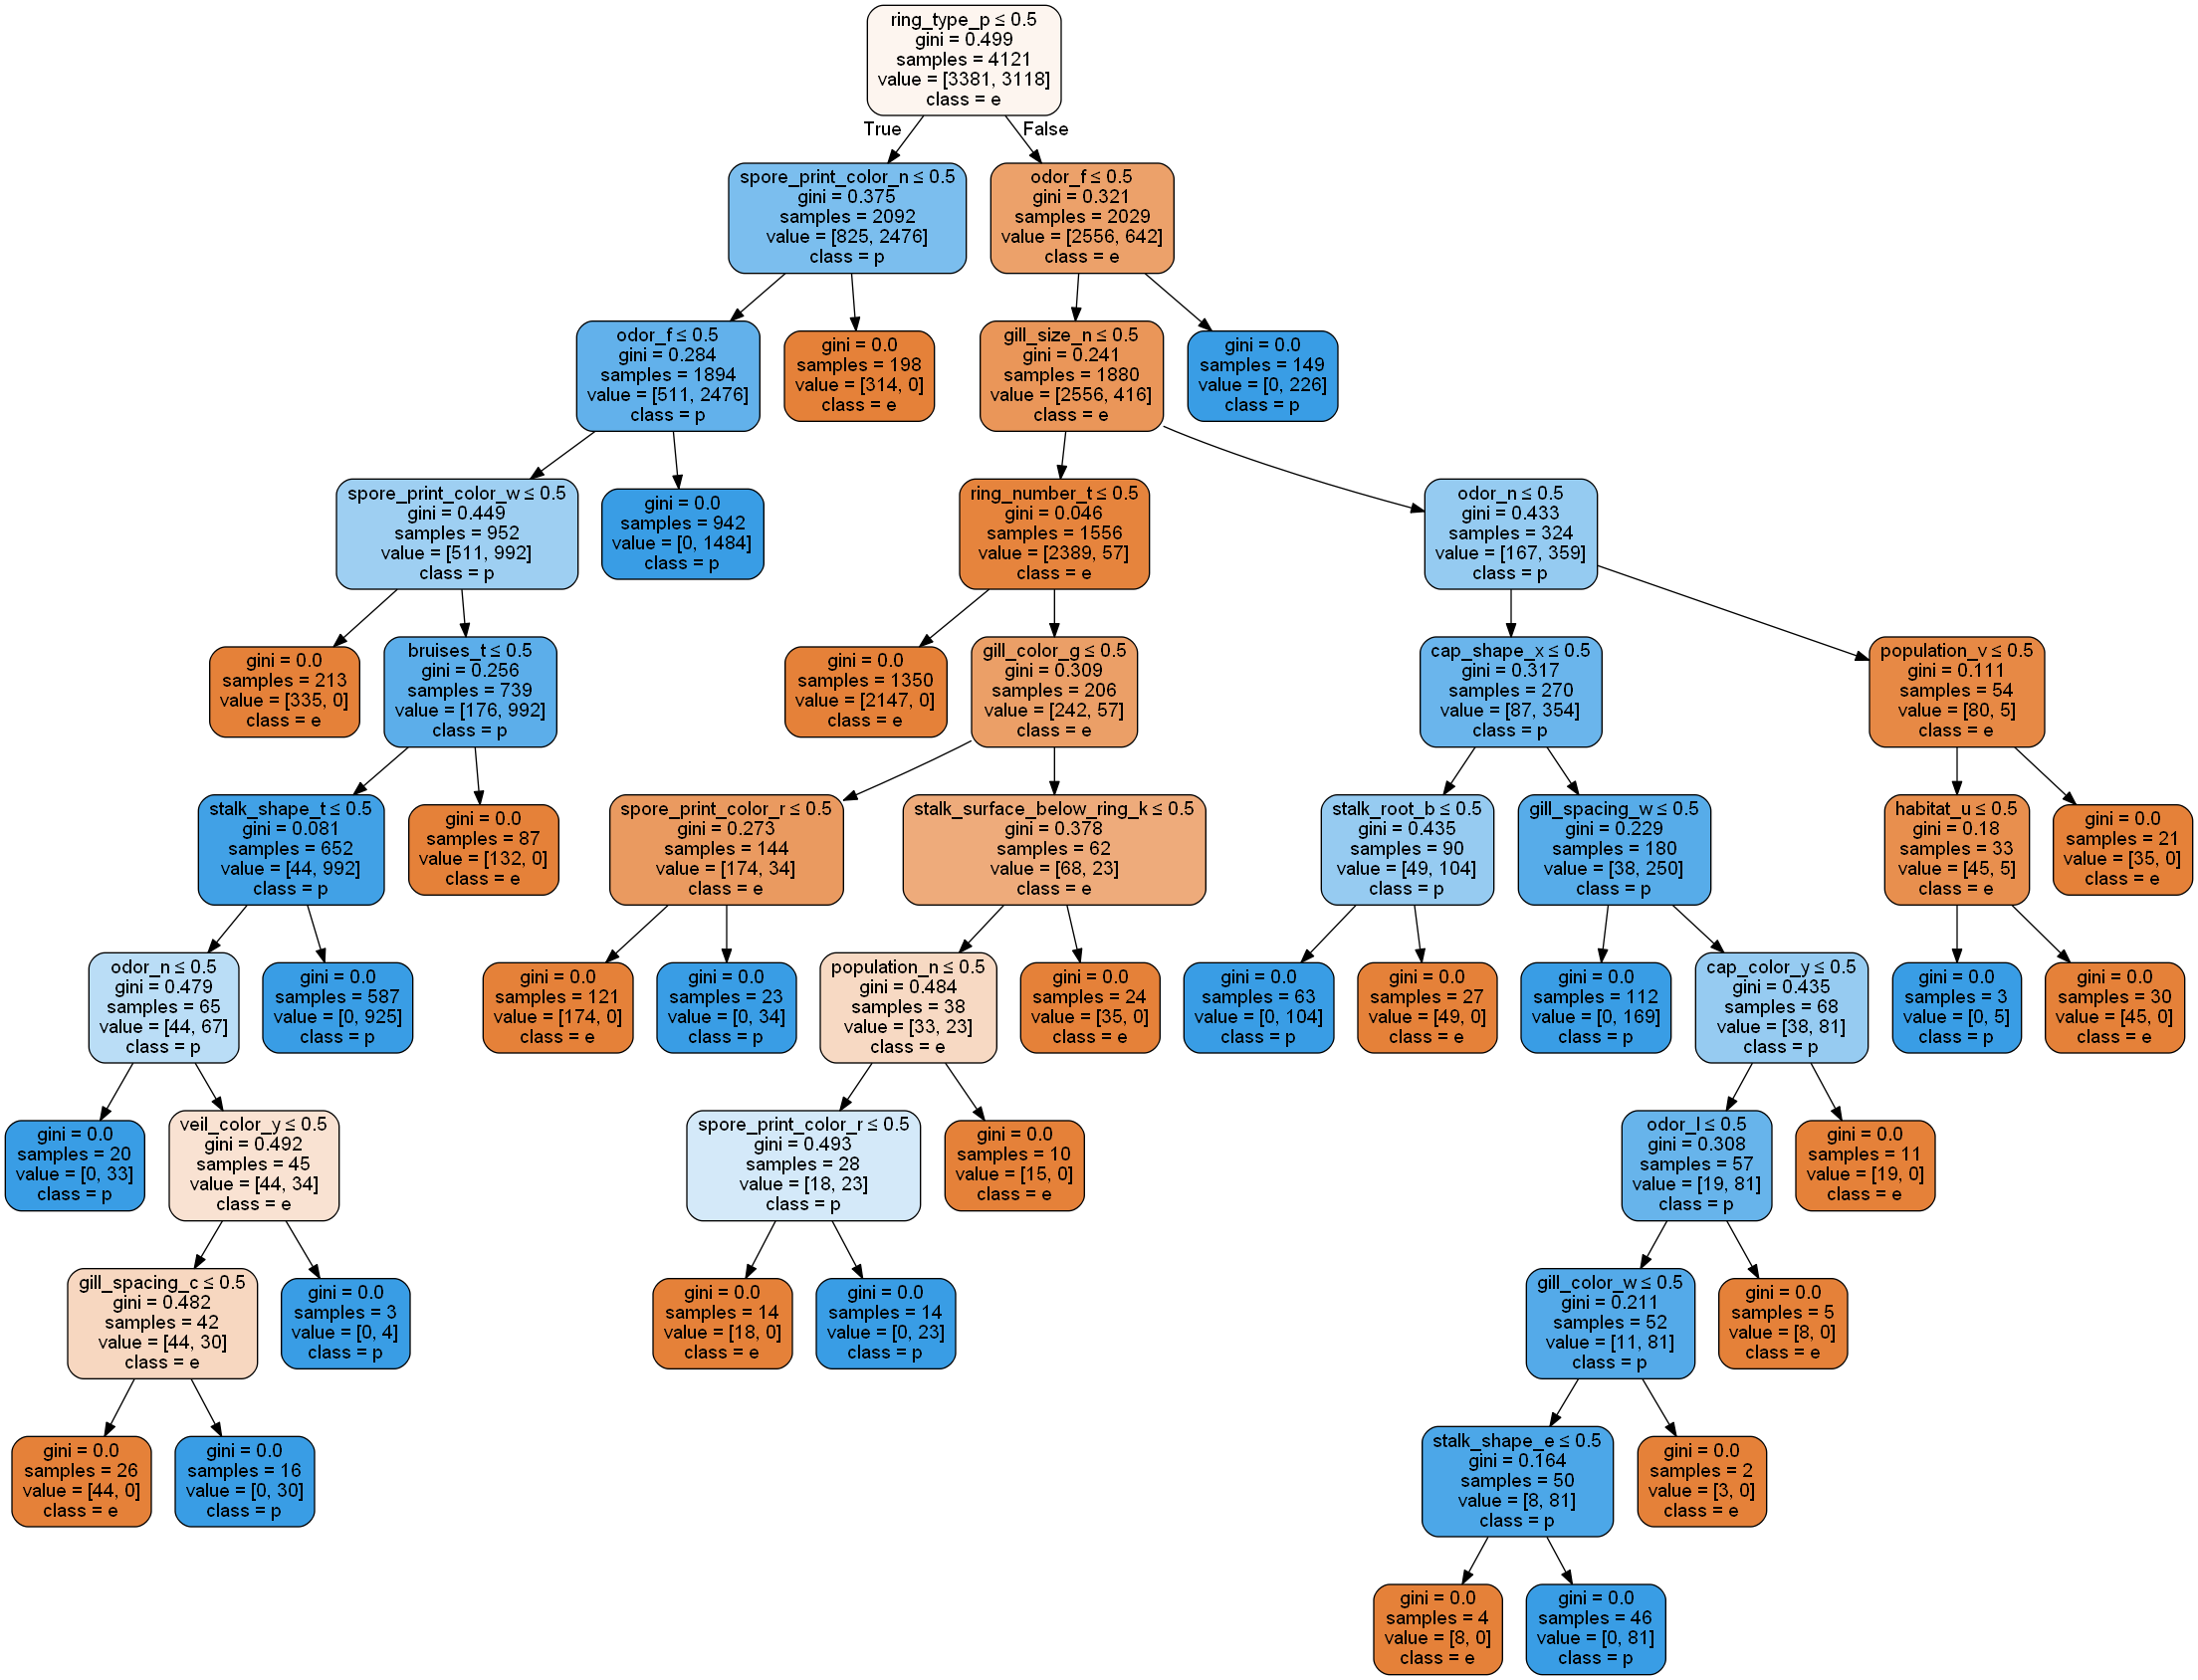

In [23]:
dot_data = StringIO()

tree.export_graphviz(rfc_oh.estimators_[7], out_file=dot_data, 
                feature_names=Xoh_test.columns, class_names=['e','p'],
                filled=True, rounded=True, special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### XGBoost

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       841
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1624
   macro avg       1.00      1.00      1.00      1624
weighted avg       1.00      1.00      1.00      1624



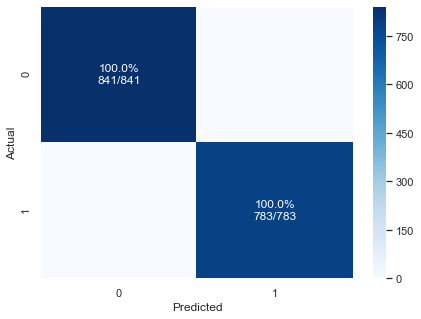

In [183]:
xgbc = xgb.XGBClassifier(n_jobs=-1,random_state=RS)
xgbc.fit(X_train,y_train)
preds = xgbc.predict(X_test)
pplot_cm(y_test, preds, xgbc.classes_, cf_report=True, figsize=(7,5), cmap='Blues')

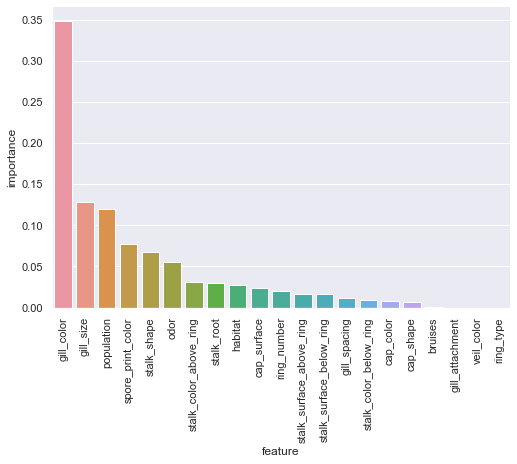

In [184]:
xgbc_fi = pd.DataFrame({'feature':X.columns,'importance':xgbc.feature_importances_}).sort_values(by='importance',ascending=False)
sns.catplot(x='feature',y='importance',data=xgbc_fi,kind='bar',aspect=1.5).set_xticklabels(rotation=90);

TODO: correct statement. XGBoost feature importance calculation changed.

~~Again, we see odor as the most important variable, this time however, spore_print_color came in with second importance, which is what our randomly chosen decision tree estimator from the RF model used as a 2nd split.~~

#### One-hot encoding

              precision    recall  f1-score   support

           e       1.00      1.00      1.00       840
           p       1.00      1.00      1.00       785

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



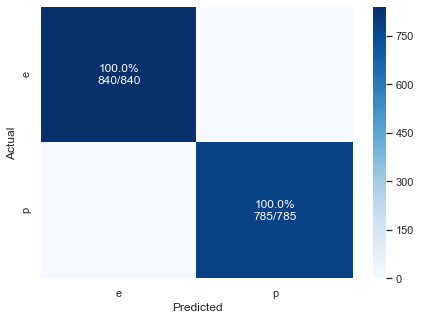

In [185]:
xgbc_oh = xgb.XGBClassifier(n_jobs=-1,random_state=RS)
xgbc_oh.fit(Xoh_train,yoh_train)
preds = xgbc_oh.predict(Xoh_test)
pplot_cm(yoh_test, preds, xgbc_oh.classes_, cf_report=True, figsize=(7,5), cmap='Blues')

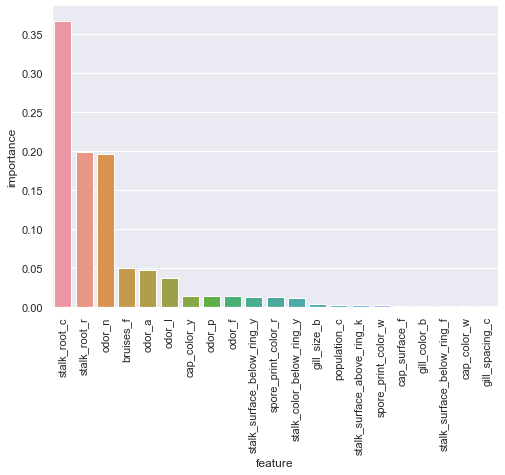

In [186]:
xgbc_oh_fi = pd.DataFrame({'feature':Xoh.columns,'importance':xgbc_oh.feature_importances_}).sort_values(by='importance',ascending=False)
sns.catplot(x='feature',y='importance',data=xgbc_oh_fi[:21],kind='bar',aspect=1.5).set_xticklabels(rotation=90);

TODO: correct statement.

~~`odor_n` has once again taken the top spot for performance but in contrast with RandomForest one-hot, it is not completely dominating over other features.~~

#### XGBoost with DMatrix

Since XGBoost uses this dataset in its official [Get Started with XGBoost](https://xgboost.readthedocs.io/en/latest/get_started.html) tutorial, it's worth briefly mentioning here.

Another approach to using XGBoost using LibSVM formatted data. It is an extremely lightweight way to encode sparse data and has greatly improved performance, albeit at the cost of some degree of interpretability. Data is represented in a newline delimited file where each line is a data sample formated as `<target> <feat1_idx>:<feat1_val> <feat9_idx>:<feat9_val> ...`

Additional reading:
* https://xgboost.readthedocs.io/en/latest/tutorials/input_format.html#basic-input-format
* https://www.csie.ntu.edu.tw/~cjlin/libsvm/faq.html#/Q03:_Data_preparation
* https://stats.stackexchange.com/questions/61328/libsvm-data-format

In [48]:
# read in data
dtrain = xgb.DMatrix('data/agaricus.txt.train')
dtest = xgb.DMatrix('data/agaricus.txt.test')
# specify parameters via map
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)

[15:48:52] 6513x127 matrix with 143286 entries loaded from data/agaricus.txt.train
[15:48:52] 1611x127 matrix with 35442 entries loaded from data/agaricus.txt.test


In [55]:
bst.get_fscore('data/featmap.txt') # feature importances as weight

{'odor=pungent': 2,
 'stalk-root=cup': 1,
 'spore-print-color=orange': 1,
 'stalk-root=missing': 1}

`get_fscore()` uses a simple split count to determine feature importance, referred to as 'weight'. To more closely resemble the underlying method used by sklearn's RandomForest, we can instead use 'gain' in combination with `get_score()`

In [56]:
bst.get_score('data/featmap.txt', importance_type='gain')

{'odor=pungent': 2285.1280540000002,
 'stalk-root=cup': 1158.21204,
 'spore-print-color=orange': 198.173828,
 'stalk-root=missing': 832.545044}

### Model Exploration

Despite plotting out decision trees and feature importances for given data and one-hot encoded data, we still cannot definitively say exactly why our models were able to achieve perfect classification. Unless we can be certain as to what exactly contributes to our perfect classifiers, we cannot eliminate the possibility that we have made a mistake somewhere.

Let's begin by taking another look at those feature importance calculations to see why these alone aren't enough to make any definitive claims.

In [145]:
fi_merge = rfc_fi.merge(xgbc_fi, on='feature',suffixes=('_rf', '_xgb')).set_index('feature')
# One-hot encoded feature importances
fi_oh_merge = rfc_oh_fi.merge(xgbc_oh_fi, on='feature',suffixes=('_rf', '_xgb')).set_index('feature')
# Uncertainty coefficients
unc_coef = X_enc.corrwith(y_enc,method=theils_u).sort_values(ascending=False)
unc_coef_oh = Xoh.corrwith(y_enc,method=theils_u).sort_values(ascending=False)

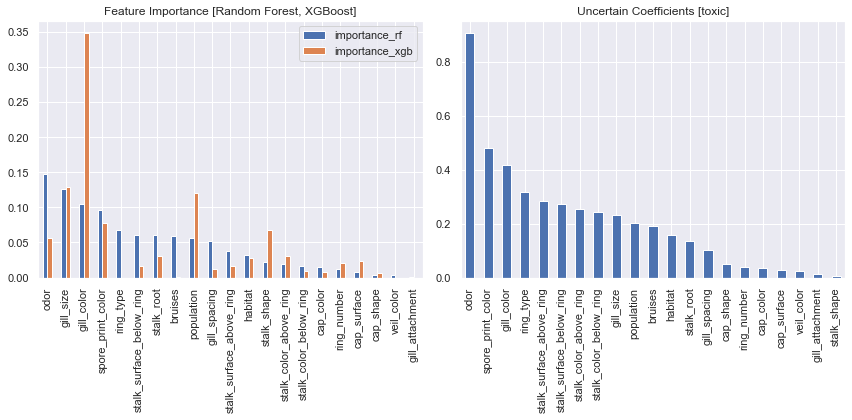

In [182]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
fi_merge.plot.bar(ax=axs[0])
unc_coef.plot.bar(ax=axs[1])
axs[0].set_xlabel(None)
axs[0].set_title('Feature Importance [Random Forest, XGBoost]')
axs[1].set_title('Uncertain Coefficients [toxic]')
plt.tight_layout()
plt.show()

Plot the importance values side by side and the issue becomes quite apparent, the models simply do not agree on which features are most important. The random forest agrees with the uncertain coefficient values in stating the a relationship between `oder` and `toxic`, but the XGBoost model has determined `gill_color` to be substantially more important.

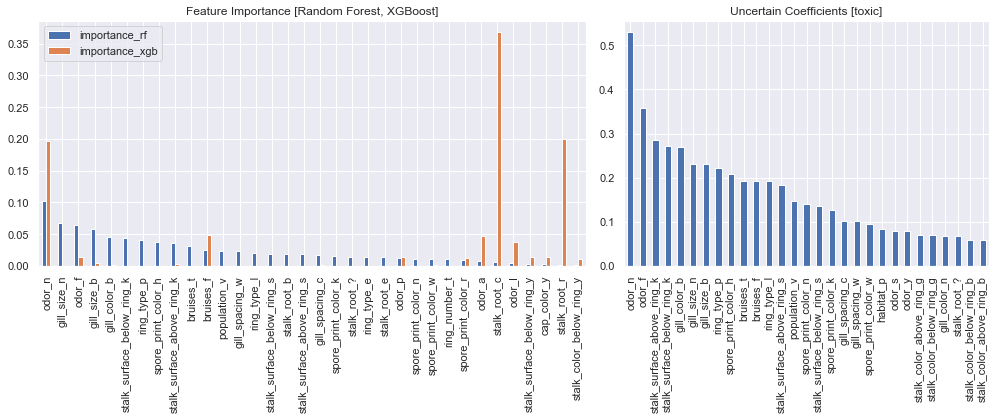

In [172]:
fig,axs=plt.subplots(1,2,figsize=(14,6),gridspec_kw=dict(width_ratios=[3, 2]))
# filter out features of little importance for plotting
fi_oh_merge.query('importance_rf > 0.01 | importance_xgb > 0.01').plot.bar(ax=axs[0])
# filter out low coefficient values
unc_coef_oh[unc_coef_oh>0.05].plot.bar(ax=axs[1])
axs[0].set_xlabel(None)
axs[0].set_title('Feature Importance [Random Forest, XGBoost]')
axs[1].set_title('Uncertain Coefficients [toxic]')
plt.tight_layout()
plt.show()

#### Permutation Importance

In [61]:
rfc_pi = eli5.sklearn.PermutationImportance(rfc).fit(X_test,y_test)

In [65]:
eli5.explain_weights(rfc_pi,feature_names=X_enc.columns.values)

Weight,Feature
0.0224 ± 0.0017,gill_size
0.0034 ± 0.0018,spore_print_color
0.0001 ± 0.0005,odor
0 ± 0.0000,cap_surface
0 ± 0.0000,ring_type
0 ± 0.0000,ring_number
0 ± 0.0000,veil_color
0 ± 0.0000,stalk_color_below_ring
0 ± 0.0000,stalk_color_above_ring
0 ± 0.0000,stalk_surface_below_ring


In [394]:
eli5.explain_prediction(rfc, X_enc.sample(1), feature_names=X_enc.columns.values)

Explanation(estimator="RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n                       max_depth=None, max_features='auto', max_leaf_nodes=None,\n                       min_impurity_decrease=0.0, min_impurity_split=None,\n                       min_samples_leaf=1, min_samples_split=2,\n                       min_weight_fraction_leaf=0.0, n_estimators=100,\n                       n_jobs=-1, oob_score=False, random_state=404, verbose=0,\n                       warm_start=False)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.48228923076923075, std=None, value=1.0), FeatureWeight(feature='spore_print_color', weight=0.30444708615833704, std=None, value=1.0), FeatureWeight(feature='odor', weight=0.17553339434522713, std=None, value=2.0), FeatureWeight(feature='stalk_surface_below_ring', weight=0.14036706083561473, std=None, value=0.0), FeatureWeight(feature='stalk_root', weight=0.04513586847694333, std=None, value=1.0), FeatureWeight(feature='gill_spacing', weight=0.01806398013185209, std=None, value=0.0), FeatureWeight(feature='population', weight=0.017091208679308915, std=None, value=4.0), FeatureWeight(feature='habitat', weight=0.016357927392599315, std=None, value=1.0), FeatureWeight(feature='stalk_shape', weight=0.014752043625681579, std=None, value=1.0), FeatureWeight(feature='cap_surface', weight=0.011813678927982492, std=None, value=2.0), FeatureWeight(feature='ring_number', weight=0.005460963974428654, std=None, value=1.0), FeatureWeight(feature='veil_color', weight=0.0019033246323514063, std=None, value=2.0), FeatureWeight(feature='gill_attachment', weight=0.0011691977868448456, std=None, value=1.0), FeatureWeight(feature='cap_shape', weight=0.0010707685497703756, std=None, value=5.0)], neg=[FeatureWeight(feature='bruises', weight=-0.05966004871342292, std=None, value=1.0), FeatureWeight(feature='gill_color', weight=-0.052837507431030176, std=None, value=7.0), FeatureWeight(feature='ring_type', weight=-0.04914012625677722, std=None, value=4.0), FeatureWeight(feature='gill_size', weight=-0.04140379879551063, std=None, value=0.0), FeatureWeight(feature='stalk_surface_above_ring', weight=-0.029207806194754306, std=None, value=2.0), FeatureWeight(feature='stalk_color_above_ring', weight=-0.0015654565912061413, std=None, value=7.0), FeatureWeight(feature='cap_color', weight=-0.0015607337903435342, std=None, value=8.0), FeatureWeight(feature='stalk_color_below_ring', weight=-8.025651312762005e-05, std=None, value=7.0)], pos_remaining=0, neg_remaining=0), proba=1.0, score=None, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

In [395]:
eli5.show_prediction(rfc, X_enc.sample(1), feature_names=X_enc.columns.values, show_feature_values=True)

#### SHAP

In [347]:
shap.initjs()

In [410]:
expln = shap.TreeExplainer(rfc)
shapvals = expln.shap_values(X_enc,y_enc)

In [420]:
X.iloc[:2,:]

,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,...,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,s,w,w,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,s,w,w,w,o,p,n,n,g


In [ ]:
expln.shap_interaction_values(X_enc)

In [403]:
shap.force_plot(expln.expected_value[0], shapvals[0][:100,:], features=X.iloc[:100,:], feature_names=X_enc.columns)

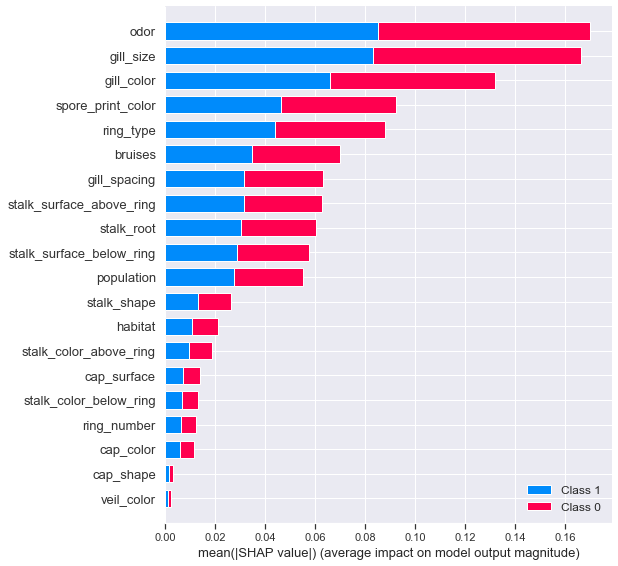

In [408]:
shap.summary_plot(shapvals, X_enc)

## Conclusions

In this notebook we used a Random Forest Classifier and XGBClassifier to attempt to determine if a particular mushroom was toxic when eaten based on its physical characteristics. 

The data was converted into the simplest possible numeric representation and a basic one-hot encoding. Using just default hyperparameters, we were able to obtain four perfect classifiers. After double checking our methods, we arrived at the conclusion that certain parts of the dataset maybe have been easier to predict than others. 

Ever model had a common feature that it found most importance `odor` and its one-hot derivations. Tracing down a decision tree from the one-hot RF gives some insight to the process, but it is still a far cry from easily interpretable.

Future work:<br>
Simplifications to the model are certainly possible, feature reduction could provide additional interpretability. PCA could be used to visualize where clustering may be present among the features. There was no parameter tweaking performed at all, this leaves a lot of untapped potential for some improvements to the models. Finally, CatBoost could work wonders with this dataset given that it is _only_ categorical values, it would be interesting to see how well it performs.

### References

#### Code:
1. https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
2. https://xgboost.readthedocs.io/en/latest/get_started.html
3. https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

#### Text:
1. https://archive.ics.uci.edu/ml/datasets/mushroom
2. https://www.kaggle.com/uciml/mushroom-classification/home

#### Other:
1. http://pbpython.com/categorical-encoding.html
2. http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
3. https://xgboost.readthedocs.io/en/latest/python/python_api.html